<table class="tfo-notebook-buttons" align="left">
<td>
    <a target="_blank" href="https://colab.research.google.com/github/Harvard-am216/2019-spring/blob/master/Labs/week4-Lab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
</table>

# 1. Transfer learning using `tensorflow_hub`

In [25]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np

from tensorflow.keras import layers

### Dataset

 For this example we'll use the TensorFlow flowers dataset: 

In [9]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`:

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this. 

The image size will be handles later.

In [10]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


The resulting object is an iterator that returns `image_batch, label_batch` pairs.

In [11]:
for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Image batch shape:  (32, 256, 256, 3)
Labe batch shape:  (32, 5)


## Simple transfer learning

Using tfhub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

### Download the headless model

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [image feature vector url from tfhub.dev](https://tfhub.dev/s?module-type=image-feature-vector) will work here.

In [12]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

Create the module, and check the expected image size:

In [13]:
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Ensure the data generator is generating images of the expected size:

In [14]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
    print("Image batch shape: ", image_batch.shape)
    print("Labe batch shape: ", label_batch.shape)
    break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


Wrap the module in a keras layer.

In [15]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [16]:
features_extractor_layer.trainable = False

### Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [17]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


When using Keras, TFHub modules need to be manually initialized.

In [18]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()
sess.run(init)

Test run a single batch, to see that the result comes back with the expected shape.

In [19]:
result = model.predict(image_batch)
result.shape

(32, 5)

### Train the model

Use compile to configure the training process:

In [20]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

Now use the `.fit` method to train the model.

To keep this example short train just a single epoch. To visualize the training progress during that epoch, use a custom callback to log the loss and accuract of each batch. 

In [21]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []
    
    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

In [22]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Epoch 1/1
114/114 [==============================] - 81s 712ms/step - loss: 0.6474 - acc: 0.7657


Now after, even just a few training iterations, we can already see that the model is making progress on the task.

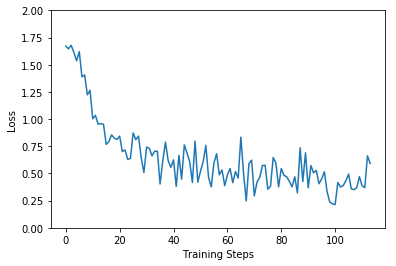

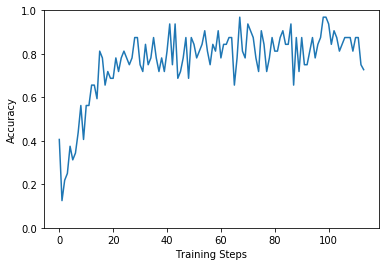

In [23]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)


### Check the predictions

To redo the plot from before, first get the ordered list of class names:

In [26]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

Run the image batch through the model and comvert the indices to class names.

In [27]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Dandelion', 'Tulips', 'Tulips', 'Roses', 'Sunflowers', 'Tulips',
       'Tulips', 'Sunflowers', 'Dandelion', 'Tulips', 'Roses', 'Tulips',
       'Tulips', 'Dandelion', 'Sunflowers', 'Tulips', 'Tulips',
       'Sunflowers', 'Sunflowers', 'Tulips', 'Sunflowers', 'Roses',
       'Sunflowers', 'Sunflowers', 'Sunflowers', 'Dandelion', 'Tulips',
       'Tulips', 'Tulips', 'Sunflowers', 'Sunflowers', 'Daisy'],
      dtype='<U10')

Plot the result

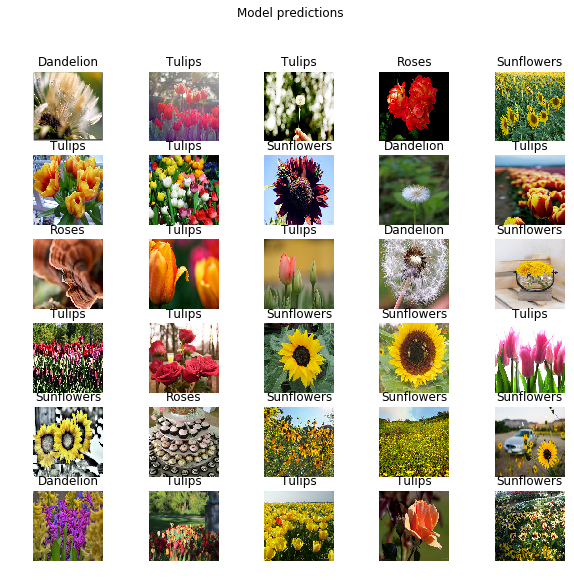

In [28]:
plt.figure(figsize=(10,9))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(labels_batch[n])
    plt.axis('off')
_ = plt.suptitle("Model predictions")

## Export your model

Now that you've trained the model, export it as a saved model:

In [0]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).



# 2. Extracting the transfer values
In this case, we just need the model layer

In [29]:
model_transfer = tf.keras.Sequential([
  features_extractor_layer
])
model_transfer.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1280)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [35]:
sess = K.get_session()
init = tf.global_variables_initializer()
sess.run(init)

In [36]:
transfer_values = model_transfer.predict(image_batch)

In [40]:
labels_batch

array(['Dandelion', 'Tulips', 'Tulips', 'Roses', 'Sunflowers', 'Tulips',
       'Tulips', 'Sunflowers', 'Dandelion', 'Tulips', 'Roses', 'Tulips',
       'Tulips', 'Dandelion', 'Sunflowers', 'Tulips', 'Tulips',
       'Sunflowers', 'Sunflowers', 'Tulips', 'Sunflowers', 'Roses',
       'Sunflowers', 'Sunflowers', 'Sunflowers', 'Dandelion', 'Tulips',
       'Tulips', 'Tulips', 'Sunflowers', 'Sunflowers', 'Daisy'],
      dtype='<U10')

We can try a PCA

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transfer_values_2d = pca.fit_transform(transfer_values)

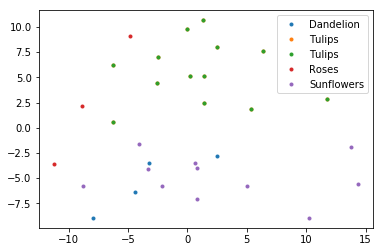

In [50]:
for i in range(len(np.unique(labels_batch))):
    plt.plot(transfer_values_2d[np.where(labels_batch == labels_batch[[i]])[0]].T[0],
        transfer_values_2d[np.where(labels_batch == labels_batch[[i]])[0]].T[1],'.', label = labels_batch[i])
plt.legend()

## Your tasks:
- ### Refer to previous labs, try a SVM or other methods.
- ### Change the model to InceptionV3 with url: "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1"
- ### Figure out what format of data these pre-trained models take. Check the `PIL` package for how to import figures